In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:

import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, explained_variance_score, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.model_selection import KFold

In [61]:
from sklearn.ensemble import RandomForestRegressor

En este proyecto analizamos la base de datos de “insurance” una base de datos de los costos del seguro médico de una aseguradora en Estados Unidos.
Realizo estadística descriptiva básica para tener una descripción de nuestra población y asi mismo realizamos un árbol de regresión con validación cruzada para conocer nuestras variables más importantes en este modelo y finalmente hacemos un pronóstico tomando como variable objetivo “charges”.


In [3]:
insurance = pd.read_csv("insurance.csv")
display(insurance)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [4]:
insurance['sex'].unique()
insurance['sex']=insurance['sex'].map({'female':0,'male':1})
insurance['region']=insurance['region'].map({'southwest':1,'southeast':2,
                   'northwest':3,'northeast':4})
insurance['smoker']= insurance['smoker'].map({'yes':1,'no':0})

In [5]:
display(insurance)

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,1,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,3,21984.47061
4,32,1,28.880,0,0,3,3866.85520
...,...,...,...,...,...,...,...
1333,50,1,30.970,3,0,3,10600.54830
1334,18,0,31.920,0,0,4,2205.98080
1335,18,0,36.850,0,0,2,1629.83350
1336,21,0,25.800,0,0,1,2007.94500


In [7]:
insurance.describe()

,age,sex,bmi,children,smoker,region,charges
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,0.505232,30.663397,1.094918,0.204783,2.484305,13270.422265
std,14.049960,0.500160,6.098187,1.205493,0.403694,1.104885,12110.011237
min,18.000000,0.000000,15.960000,0.000000,0.000000,1.000000,1121.873900
25%,27.000000,0.000000,26.296250,0.000000,0.000000,2.000000,4740.287150
50%,39.000000,1.000000,30.400000,1.000000,0.000000,2.000000,9382.033000
75%,51.000000,1.000000,34.693750,2.000000,0.000000,3.000000,16639.912515
max,64.000000,1.000000,53.130000,5.000000,1.000000,4.000000,63770.428010


Realizamos un histograma de nuestras variables, no separando genéros 

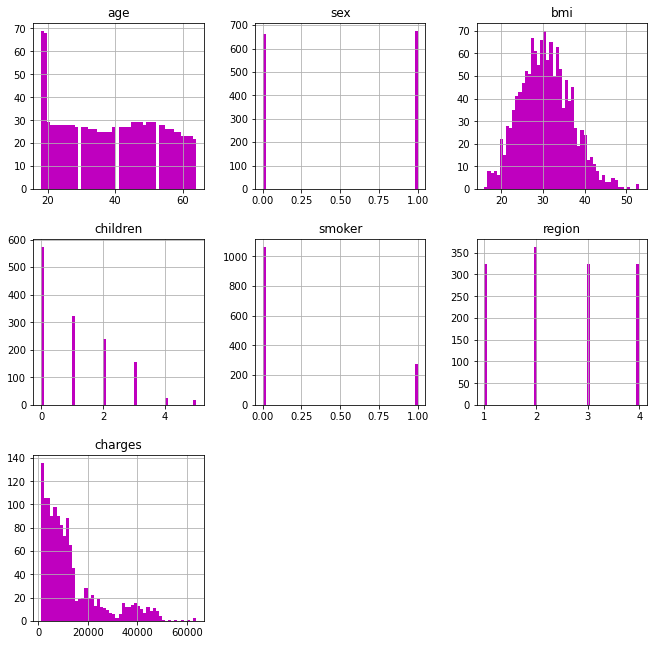

In [10]:
ax = insurance.hist(bins=50, figsize=(11,11), color = "#BF00BF")

In [17]:
femenino = insurance['sex'] == 0
masculino = insurance['sex'] == 1


In [19]:
mujeres = insurance[femenino]
hombres = insurance[masculino]
bmi = [mujeres['bmi'], hombres['bmi']]
children = [mujeres['children'], hombres['children']]
age = [mujeres['age'], hombres['age']]
smoker = [mujeres['smoker'], hombres['smoker']]
region = [mujeres['region'], hombres['region']]
charges = [mujeres['charges'], hombres['charges']]

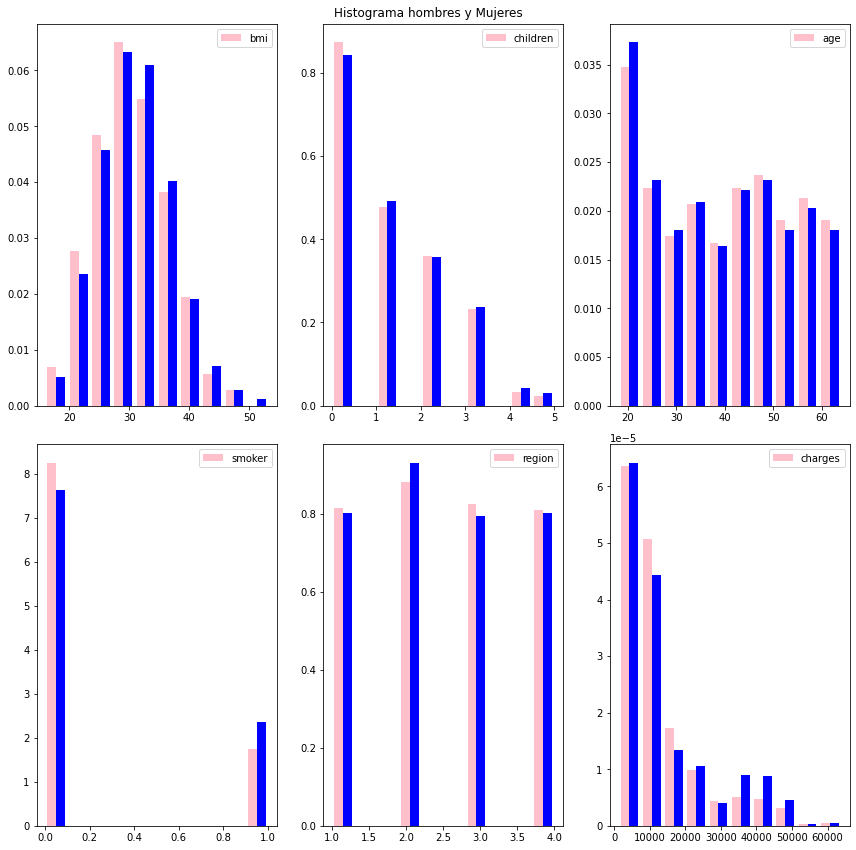

In [141]:

fig, axs = plt.subplots(nrows=2, ncols=3,figsize=(12,12))
colors = ['pink','blue']

fig.suptitle('Histograma hombres y Mujeres')
axs[0,0].hist(bmi, density = True, color = colors, label = 'bmi')
axs[0,0].legend(prop={'size': 10})
axs[0,1].hist(children,density = True, color = colors,label = 'children')
axs[0,1].legend(prop={'size': 10})
axs[0,2].hist(age,density = True, color = colors, label = 'age')
axs[0,2].legend(prop={'size': 10})
axs[1,0].hist(smoker,density = True, color = colors, label = 'smoker')
axs[1,0].legend(prop={'size': 10})
axs[1,1].hist(region,density = True, color = colors, label = 'region')
axs[1,1].legend(prop={'size': 10})
axs[1,2].hist(charges,density = True, color = colors, label = 'charges')
axs[1,2].legend(prop={'size': 10})
fig.tight_layout()

plt.show()

Revisamos la correlación entre las variables para identificar cuáles podrían generar ruido en nuestro modelo.

In [8]:
cor = insurance.corr()
display(cor)

,age,sex,bmi,children,smoker,region,charges
age,1.000000,-0.020856,0.109272,0.042469,-0.025019,-0.002127,0.299008
sex,-0.020856,1.000000,0.046371,0.017163,0.076185,-0.004588,0.057292
bmi,0.109272,0.046371,1.000000,0.012759,0.003750,-0.157566,0.198341
children,0.042469,0.017163,0.012759,1.000000,0.007673,-0.016569,0.067998
smoker,-0.025019,0.076185,0.003750,0.007673,1.000000,0.002181,0.787251
region,-0.002127,-0.004588,-0.157566,-0.016569,0.002181,1.000000,0.006208
charges,0.299008,0.057292,0.198341,0.067998,0.787251,0.006208,1.000000


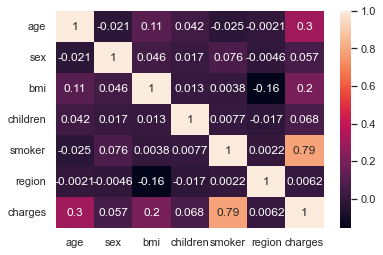

In [27]:
ax = sns.heatmap(insurance.corr(method = 'pearson'), annot=True)


Podemos dividar la población de acuerdo a indice de masa coorporal 

In [6]:
bmi = insurance['bmi'] >= 24.9

In [7]:
personas_en_riesgo = insurance[bmi]
display(personas_en_riesgo)

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.90,0,1,1,16884.9240
1,18,1,33.77,1,0,2,1725.5523
2,28,1,33.00,3,0,2,4449.4620
4,32,1,28.88,0,0,3,3866.8552
5,31,0,25.74,0,0,2,3756.6216
...,...,...,...,...,...,...,...
1333,50,1,30.97,3,0,3,10600.5483
1334,18,0,31.92,0,0,4,2205.9808
1335,18,0,36.85,0,0,2,1629.8335
1336,21,0,25.80,0,0,1,2007.9450


In [8]:
bmi_bajo = insurance['bmi'] < 24.9

In [9]:
personas_sanas = insurance[bmi_bajo]
display(personas_sanas)

,age,sex,bmi,children,smoker,region,charges
3,33,1,22.705,0,0,3,21984.47061
15,19,1,24.600,1,0,1,1837.23700
17,23,1,23.845,0,0,4,2395.17155
26,63,0,23.085,0,0,4,14451.83515
28,23,1,17.385,1,0,3,2775.19215
...,...,...,...,...,...,...,...
1304,42,1,24.605,2,1,4,21259.37795
1306,29,0,21.850,0,1,4,16115.30450
1314,30,0,23.655,3,1,3,18765.87545
1316,19,0,20.600,0,0,1,1731.67700


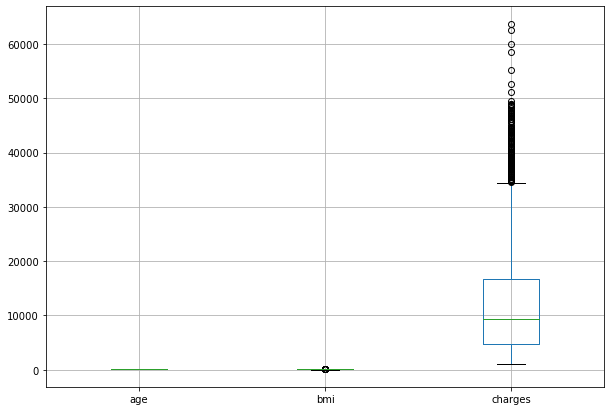

In [11]:
fig = plt.figure(figsize =(10, 7))
b_plot = insurance.boxplot(column = ['age', 'bmi', 'charges']) 
b_plot.plot()

plt.show()

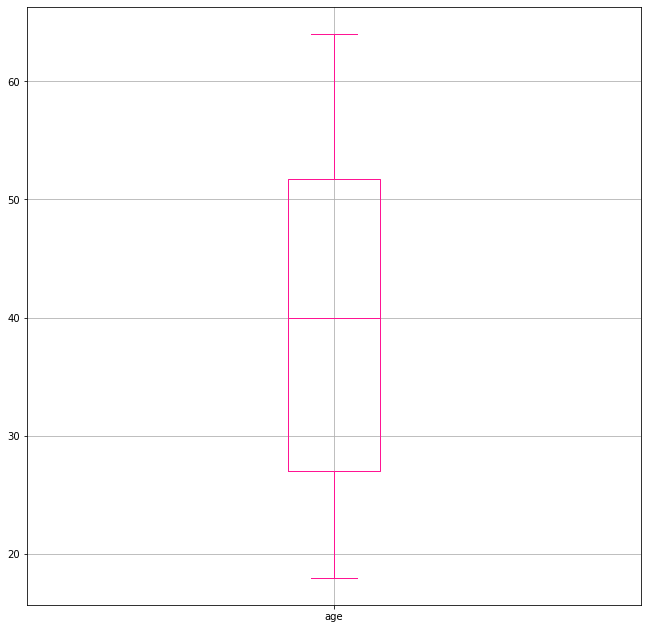

In [20]:
b_plot = mujeres.boxplot(column = ['age'], figsize=(11,11),grid = True, color = "#FF1493")
b_plot.plot()
plt.show()

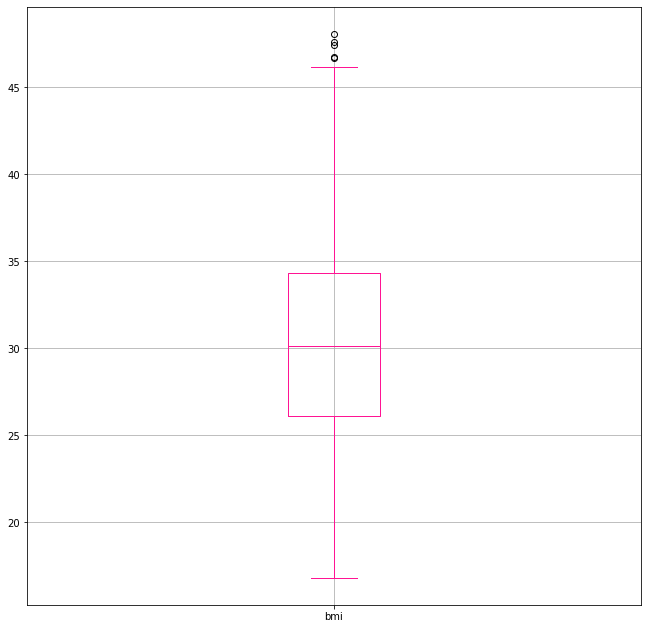

In [22]:
b_plot = mujeres.boxplot(column = ['bmi'], figsize=(11,11),grid = True, color = "#FF1493")
b_plot.plot()
plt.show()

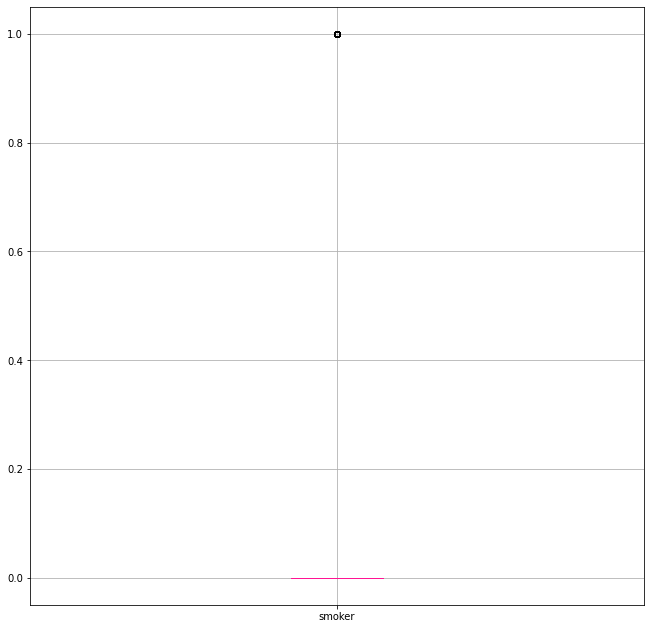

In [25]:
b_plot = mujeres.boxplot(column = ['smoker'], figsize=(11,11),grid = True, color = "#FF1493")
b_plot.plot()
plt.show()

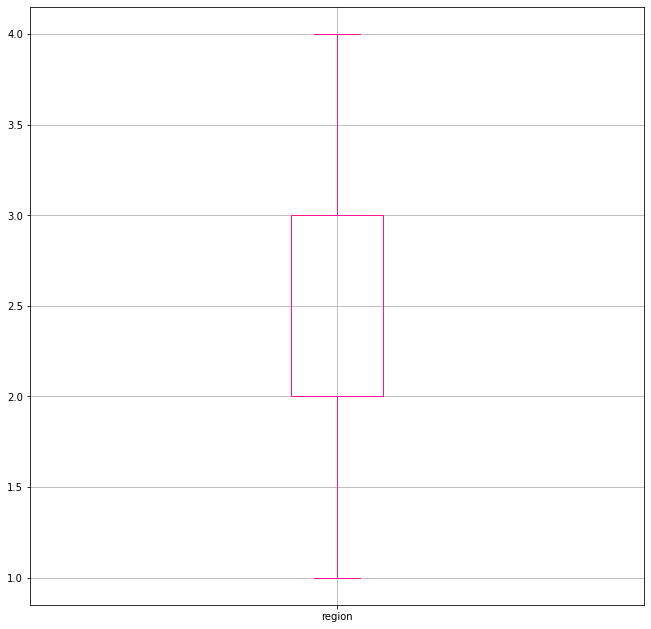

In [27]:
b_plot = mujeres.boxplot(column = ['region'], figsize=(11,11),grid = True, color = "#FF1493")
b_plot.plot()
plt.show()

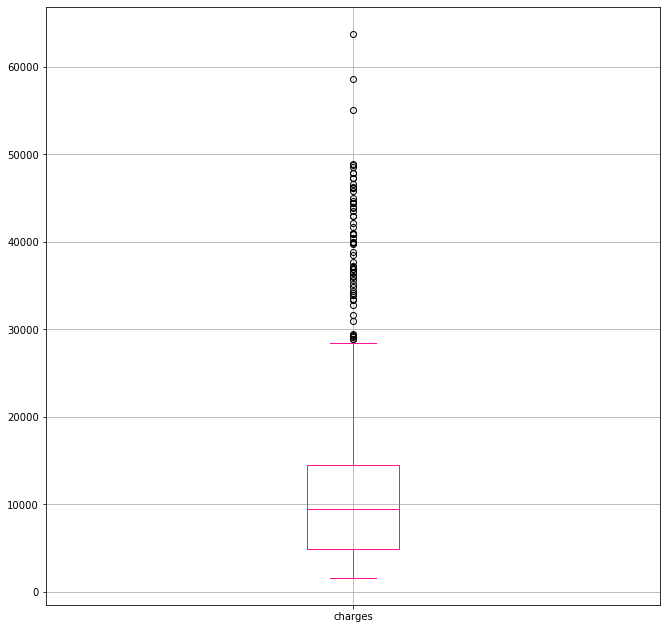

In [28]:
b_plot = mujeres.boxplot(column = ['charges'], figsize=(11,11),grid = True, color = "#FF1493")
b_plot.plot()
plt.show()

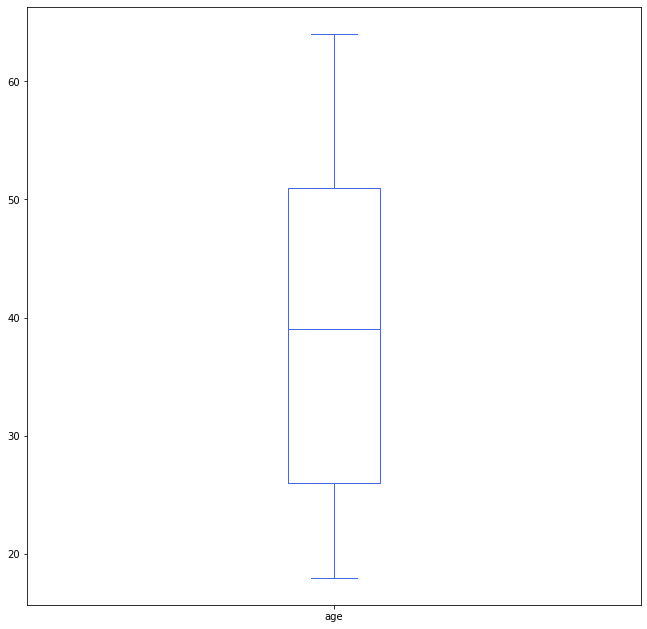

In [29]:
b_plot = hombres.boxplot(column = ['age'], figsize=(11,11),grid = False, color = "#4169E1")
b_plot.plot()
plt.show()

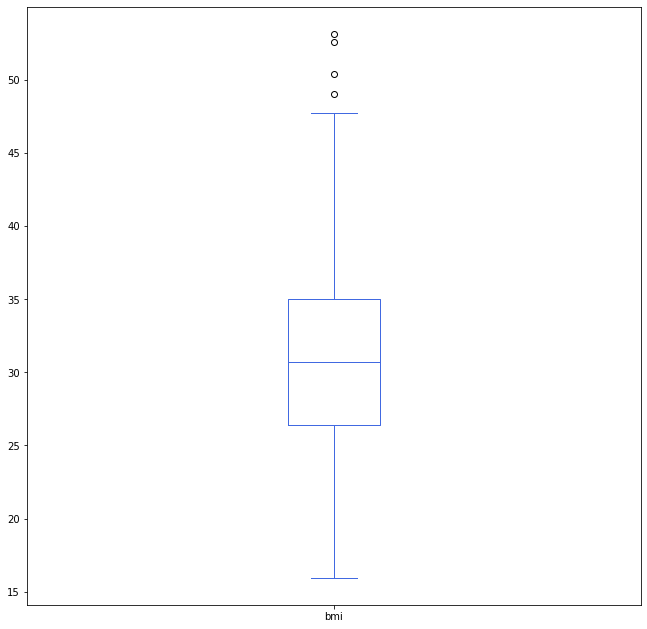

In [49]:
b_plot = hombres.boxplot(column = ['bmi'], figsize=(11,11),grid = False, color = "#4169E1")
b_plot.plot()
plt.show()

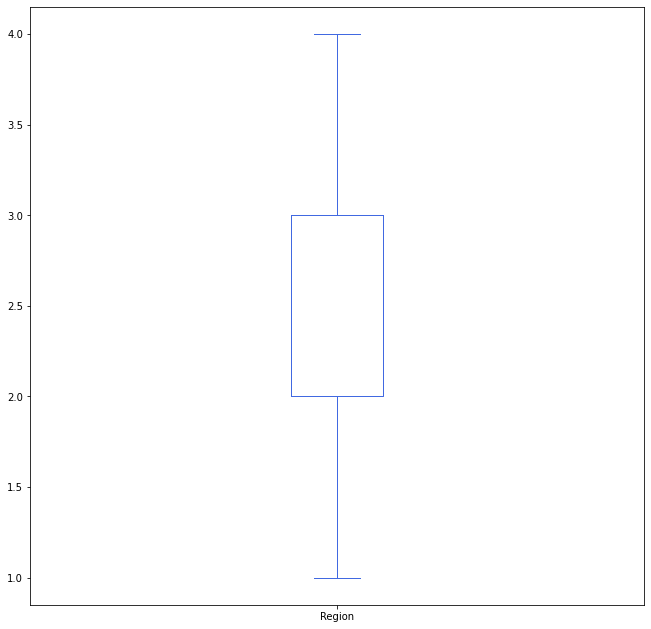

In [50]:
b_plot = hombres.boxplot(column = ['Region'], figsize=(11,11),grid = False, color = "#4169E1")
b_plot.plot()
plt.show()

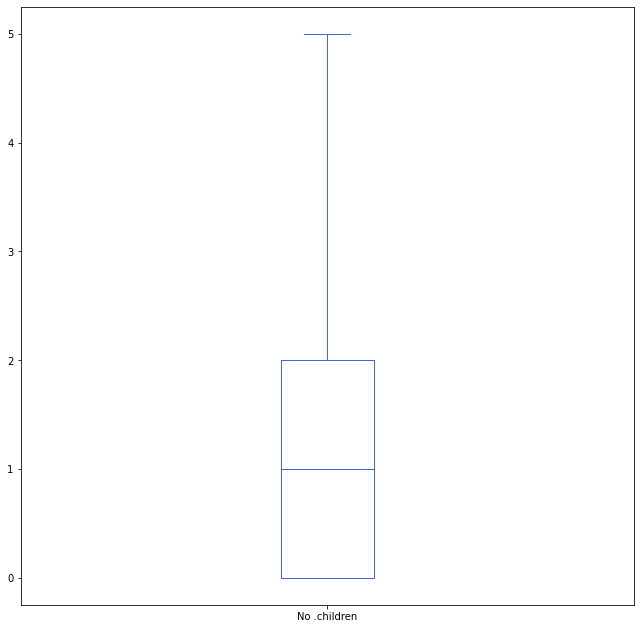

In [51]:
b_plot = hombres.boxplot(column = ['No .children'], figsize=(11,11),grid = False, color = "#4169E1")
b_plot.plot()
plt.show()

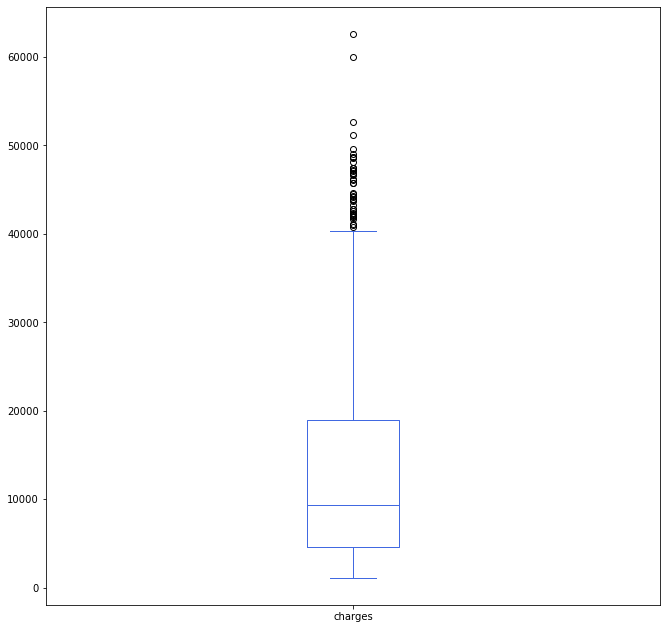

In [53]:
b_plot = hombres.boxplot(column = ['charges'], figsize=(11,11),grid = False, color = "#4169E1")
b_plot.plot()
plt.show()

Empezamos con nuestro árbol de decisiones, tomamos como variable objetivo nuestra variable “charges” y en este análisis no contaremos como variable dependiente a la variable “región” 

In [31]:
x = ['age','sex','bmi','children','smoker']
y = ['charges']

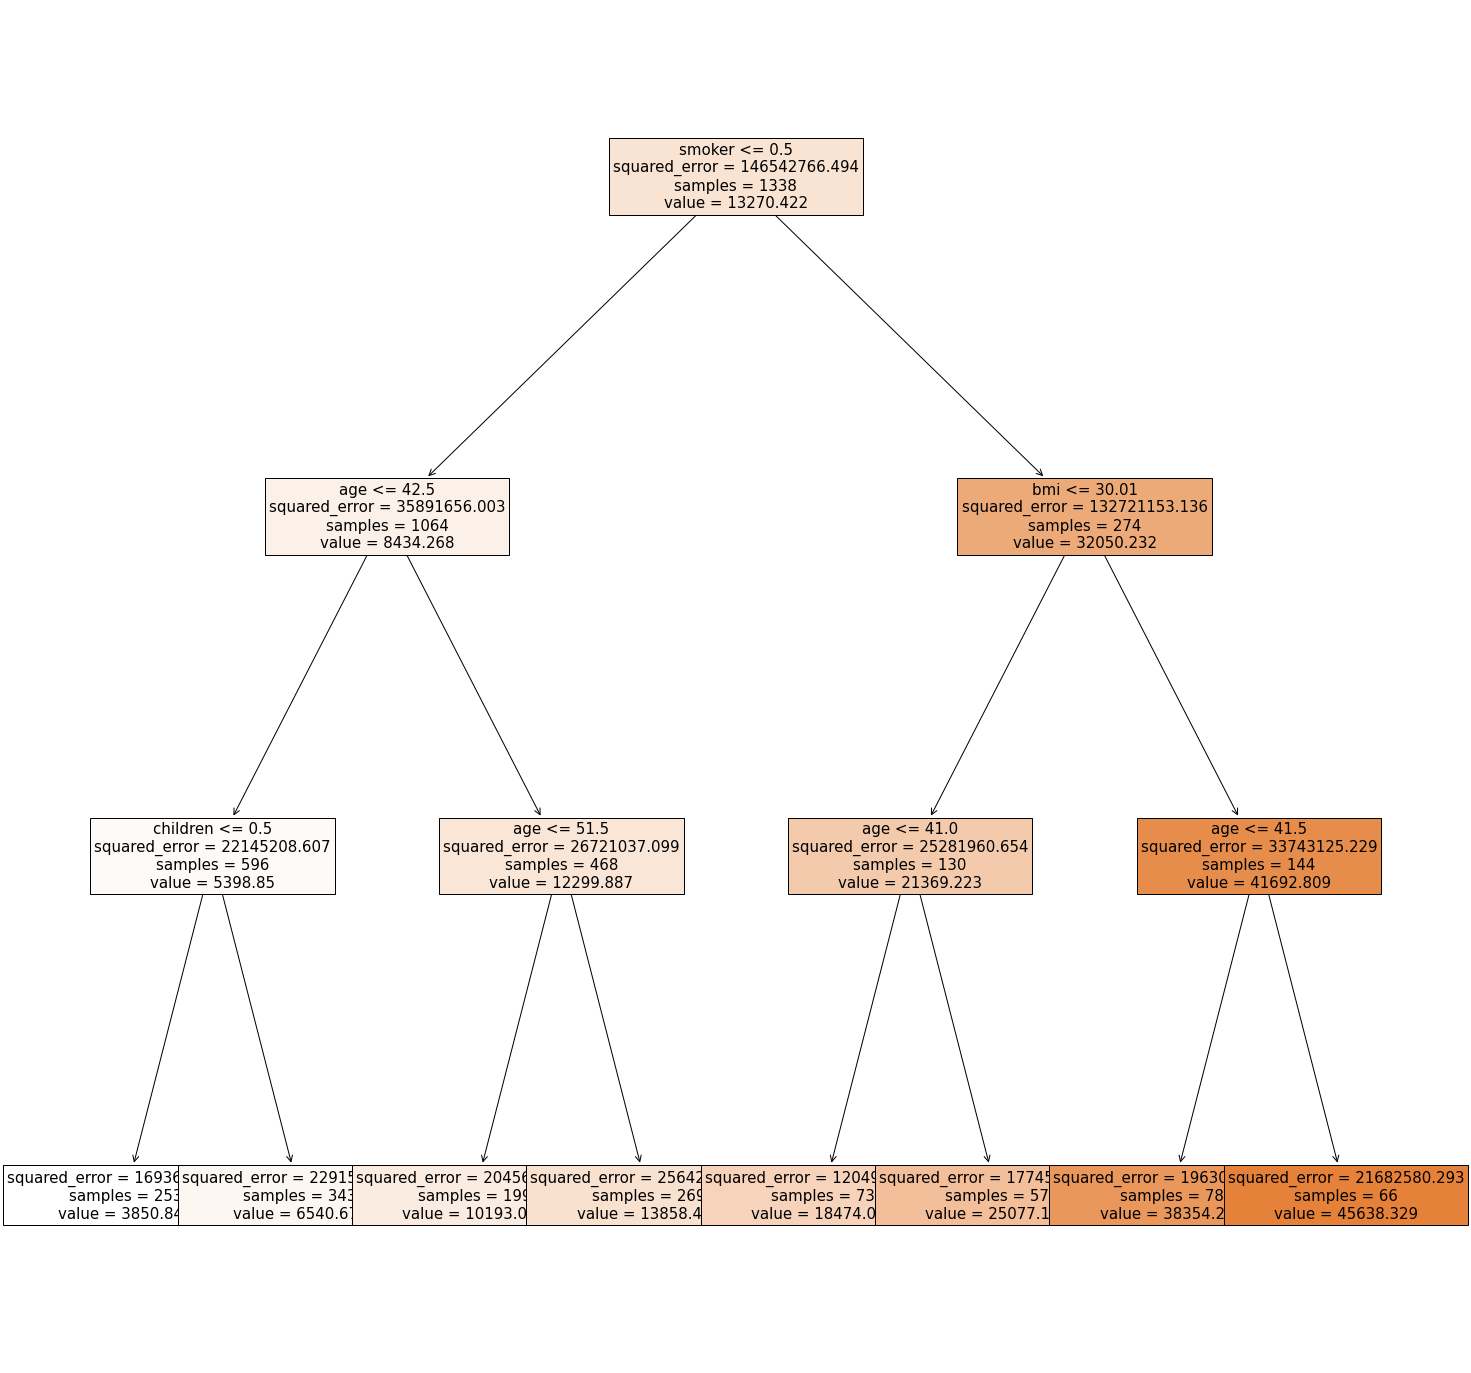

In [33]:
max_depth = 3

splits = 3
min_samples_leaf = 3

X = insurance[x]
Y = insurance[y]
regressor = DecisionTreeRegressor(
                            max_depth=max_depth,
                            min_samples_leaf=min_samples_leaf)\
                        .fit(X,Y)

plt.figure(figsize=(25,25))
ars = plot_tree(regressor,feature_names=x,class_names=y, fontsize=15,filled= True)

Realizamos validación cruzada para nuestro arbol y obtenemos que nuestro modelo explica 84% de la varianza explicada

In [35]:
Y_est = []
i=1
kfolds = KFold(n_splits=splits)
for train_index, test_index in kfolds.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    Y_train, Y_test = Y.loc[train_index], Y.loc[test_index]
    kfold_regressor = DecisionTreeRegressor(
                            max_depth=max_depth,
                            min_samples_leaf=min_samples_leaf)\
                        .fit(X_train,Y_train)
    Y_k_est = kfold_regressor.predict(X_test)
    Y_est += list(Y_k_est)
    print('R2=',r2_score(Y_test,Y_k_est))
    i += 1
insurance[y[0]+'_est']=Y_est

print('-'*50)
print('R2=',r2_score(insurance[y], insurance[y[0]+'_est']))

R2= 0.855187837653487
R2= 0.8399941508934308
R2= 0.8298161068435329
--------------------------------------------------
R2= 0.8419005973988058


Realizamos un DataFrame aleatorio y pronosticamos cuanto gastaria estos individuos

In [55]:
rf = RandomForestRegressor()
rf.fit(X_train,Y_train.values.ravel())

RandomForestRegressor()

In [56]:
y_pred3 = rf.predict(X_test)

In [57]:
data = pd.DataFrame()
data['age'] = [25,56,18,67,33]
data['sex'] = [1,0,1,0,0]
data['bmi'] = [18.7,25.4,30.1,22,18.5]
data['children'] = [4,0,0,2,1]
data['smoker'] = [1,0,1,0,0]

In [46]:
display(data)

,age,sex,bmi,children,smoker
0,25,1,18.7,4,1
1,56,0,25.4,0,0
2,18,1,30.1,0,1
3,67,0,22.0,2,0
4,33,0,18.5,1,0


In [58]:
new_pred = rf.predict(data)
print("Costo del seguro : ",new_pred[0])
print("Costo del seguro : ",new_pred[1])
print("Costo del seguro : ",new_pred[2])
print("Costo del seguro : ",new_pred[3])
print("Costo del seguro : ",new_pred[4])

Costo del seguro :  16339.594005800001
Costo del seguro :  11325.709189600006
Costo del seguro :  22603.376187299975
Costo del seguro :  17936.605736599988
Costo del seguro :  6844.957670399999


In [59]:
display(insurance)

,age,sex,bmi,children,smoker,region,charges,charges_est
0,19,0,27.900,0,1,1,16884.92400,18725.779404
1,18,1,33.770,1,0,2,1725.55230,6743.712535
2,28,1,33.000,3,0,2,4449.46200,6743.712535
3,33,1,22.705,0,0,3,21984.47061,3613.543784
4,32,1,28.880,0,0,3,3866.85520,3613.543784
...,...,...,...,...,...,...,...,...
1333,50,1,30.970,3,0,3,10600.54830,10545.342082
1334,18,0,31.920,0,0,4,2205.98080,3089.647056
1335,18,0,36.850,0,0,2,1629.83350,3089.647056
1336,21,0,25.800,0,0,1,2007.94500,3089.647056


<function matplotlib.pyplot.show(close=None, block=None)>

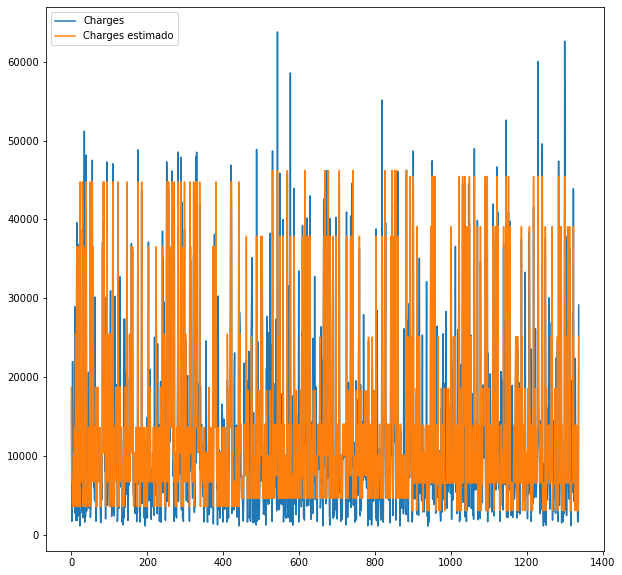

In [60]:
plt.figure(figsize=(10,10))
plt.plot(insurance['charges'], label='Charges')
plt.plot(Y_est,label = 'Charges estimado')
plt.legend()
plt.show